# Applying Computation in Superposition to transcoders

# Setup

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath('../transcoder_circuits/'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

from sae_training.sparse_autoencoder import SparseAutoencoder
from utils import tokenize_and_concatenate

In [4]:
import torch
import numpy as np
from einops import *
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Load model & data

In [59]:
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2-small').to(device)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  mps


In [60]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

# Load transcoder

In [ ]:
transcoder_template = "../dufensky_transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
sparsities = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    sparsities.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [7]:
transcoder_layer = 8
transcoder_template = "../dufensky_transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(transcoder_layer)}.pt").to(device).eval()
sparsity = torch.load(f"{transcoder_template.format(transcoder_layer)}_log_feature_sparsity.pt")
live_features = np.arange(len(sparsity))[utils.to_numpy(sparsity > -4)]

# Find transcoder's intermediate vectors
For an encoder directions $\mathbf{e}_i$ with activation $z_i(x)$, we can find directions $\mathbf{d}_i$ such that $Wx \approx \sum_i z_i(x) \mathbf{d}_i$

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.mps.empty_cache()

In [ ]:
from midcoder import MidcoderConfig, Midcoder

config = MidcoderConfig()
config.device = device
config.batch_size = 64
config.steps_per_epoch = 10
config.train_tokens = 100_000
config.log = False
midcoder = Midcoder({'model':model, 'transcoder':transcoder}, transcoder_layer, config)

In [ ]:
midcoder.fit()

# Compare decoder features to predicted values

In [ ]:
from midcoder import MidcoderConfig, Midcoder

config = MidcoderConfig()
config.device = 'mps'
config.mid_dim = 'd_mlp'
midcoder = Midcoder({'model':model, 'transcoder':transcoder}, transcoder_layer, config)

path = '../data/midcoder_layer8_v4_200M_tokens.pt'
midcoder.load_weights(path, strict=False)

In [ ]:
feat_ids = midcoder.feat_ids.cpu()

In [ ]:
sparsity_mask = sparsity[feat_ids] > -4

x = np.arange(len(sparsity))
y = sparsity.sort().values
plt.plot(x,y)
plt.xlabel('rank')
plt.ylabel('Log freq')
plt.title('Feature sparsity')

In [ ]:
act_gate_counts = midcoder.gate_act_counts[sparsity_mask]
act_gate_mean = midcoder.act_gate_sum[sparsity_mask]/midcoder.act_counts[sparsity_mask].unsqueeze(1)
act_gate_mean = act_gate_mean.detach()


plt.figure(figsize=(5,4), dpi=150)
plt.hist(act_gate_mean[:500].flatten().cpu(), 100)
plt.yscale('log')
plt.xlabel('Elementwise E[act * gate | act > 0]')
plt.ylabel('Counts')
plt.title('Distribution of activation*gate averages')

In [ ]:
mid_vector = midcoder.W_mid[feat_ids][sparsity_mask].detach()
b_mid = midcoder.b_mid

gate_mean = midcoder.gate_act_counts[sparsity_mask].detach() / midcoder.act_counts[sparsity_mask].unsqueeze(1)

pre_relu_mean = midcoder.pre_relu_sum.detach() / (midcoder.counts)
# mlp_out_mean = midcoder.mlp_out_sum.detach() / (midcoder.counts)
# b_out = midcoder.b_dec_out.detach()
# b_mid_out = midcoder.b_mid_out.detach()

pred_decoder = (act_gate_mean * mid_vector) @ midcoder.W_out
decoder = midcoder.W_dec[feat_ids][sparsity_mask].detach()



In [ ]:
cos_sims = torch.nn.functional.cosine_similarity(decoder, pred_decoder, dim=1)

freq = midcoder.act_counts[sparsity_mask] / midcoder.counts

plt.figure(figsize=(8,3.5), dpi=150, layout='tight')
plt.subplot(1,2,1)
plt.hist(cos_sims.cpu(), 500)
plt.yscale('log')
plt.xlabel('Cosine Similarity')
plt.ylabel('Counts')
plt.suptitle('Comparison of decoder and predicted decoder')

plt.subplot(1,2,2)
# plt.plot(sparsity[sparsity_mask], cos_sims.cpu(), '.', alpha=0.03)
plt.plot(freq.cpu(), cos_sims.cpu(), '.', alpha=0.1)
plt.xlabel('Activation Frequency')
plt.ylabel('Cosine Similarity')
plt.xscale('log')
# plt.title('Comparison of decoder and predicted decoder')

In [ ]:
mask = sparsity[feat_ids][sparsity_mask] > -2

plt.figure(figsize=(9,3.5), dpi=150, layout='tight')
plt.subplot(1,2,1)
sims = []

idxs = range(10)
for k in idxs:
    dec = decoder[mask][k]
    pred = pred_decoder[mask][k]
    dec /= dec.norm()
    pred /= pred.norm()
    sims.append(f'{cos_sims[mask][k].item():.2f}')
    plt.plot(dec.cpu(), pred.cpu(),'.', label=f'{cos_sims[mask][k].item():.2f}')
vec = np.arange(-0.15, 0.15, 0.01)
plt.plot(vec, vec, 'k--')
plt.legend(title='Cos Sims', prop={'size':7})
plt.ylabel('Predicted decoder')
plt.xlabel('Decoder')
plt.title('Elementwise comparison')
plt.xlim((-0.15,0.15))
plt.ylim((-0.15, 0.15))


plt.subplot(1,2,2)
for k in idxs:
    log_counts = torch.log10(act_gate_counts[mask][k] + 1e-1)
    plt.hist(log_counts.cpu(), 50, histtype='step')
plt.yscale('log')
plt.ylabel('')
plt.xlabel('Log10( Counts for Act > 0 and Gate = 1)', fontsize=12)
plt.title('Distribution of counts')

plt.suptitle('High freq features')
print(sims)

In [ ]:
mask = (sparsity[feat_ids][sparsity_mask] > -3) & (sparsity[feat_ids][sparsity_mask] < -2.5)

plt.figure(figsize=(9,3.5), dpi=150, layout='tight')
plt.subplot(1,2,1)
sims = []

idxs = range(10)
for k in idxs:
    dec = decoder[mask][k]
    pred = pred_decoder[mask][k]
    dec /= dec.norm()
    pred /= pred.norm()
    sims.append(f'{cos_sims[mask][k].item():.2f}')
    plt.plot(dec.cpu(), pred.cpu(),'.', label=f'{cos_sims[mask][k].item():.2f}')
vec = np.arange(-0.15, 0.15, 0.01)
plt.plot(vec, vec, 'k--')
plt.legend(title='Cos Sims', prop={'size':7})
plt.ylabel('Predicted decoder')
plt.xlabel('Decoder')
plt.title('Elementwise comparison')
plt.xlim((-0.15,0.15))
plt.ylim((-0.15, 0.15))


plt.subplot(1,2,2)
for k in idxs:
    log_counts = torch.log10(act_gate_counts[mask][k] + 1e-1)
    plt.hist(log_counts.cpu(), 50, histtype='step')
plt.yscale('log')
plt.ylabel('')
plt.xlabel('Log10( Counts for Act > 0 and Gate = 1)', fontsize=12)
plt.title('Distribution of counts')

plt.suptitle('Med freq features')

print(sims)

In [ ]:
mask = cos_sims < 0.7

plt.figure(figsize=(8,3.5), dpi=150, layout='tight')
plt.subplot(1,2,1)
sims = []

idxs = range(8)
for k in idxs:
    dec = decoder[mask][k]
    pred = pred_decoder[mask][k]
    dec /= dec.norm()
    pred /= pred.norm()
    sims.append(f'{cos_sims[mask][k].item():.2f}')
    plt.plot(dec.cpu(), pred.cpu(),'.', label=f'{cos_sims[mask][k].item():.2f}')
vec = np.arange(-0.15, 0.15, 0.01)
plt.plot(vec, vec, 'k--')
plt.legend(title='Cos Sims', prop={'size':7})


plt.subplot(1,2,2)
for k in idxs:
    log_counts = torch.log10(act_gate_counts[mask][k] + 1e-1)
    plt.hist(log_counts.cpu(), 50, histtype='step')
plt.yscale('log')

plt.suptitle('Features with low cosine similarity')

print(sims)

In [ ]:
sing_prob.shape

In [ ]:
prob_corr_log[0][:30]

In [ ]:
prob_corr.topk()

In [ ]:
x = pair_prob / sing_prob
x = x - torch.eye(*x.shape).to('mps')
px.imshow(x.cpu(), color_continuous_scale = 'RdBu', color_continuous_midpoint = 0)

In [ ]:
x.topk(dim=1, k=3).indices[250:270]

In [ ]:
sing_prob = (midcoder.act_counts / midcoder.counts).unsqueeze(1)
pair_prob = midcoder.act_cov_counts / midcoder.counts

sort_idxs = sparsity[feat_ids][sparsity_mask].argsort(descending=True)
sing_prob = sing_prob[sparsity_mask][sort_idxs]
pair_prob = pair_prob[sparsity_mask,:][:,sparsity_mask][sort_idxs,:][:,sort_idxs]

sing_prob_var = sing_prob * (1 - sing_prob)
prob_corr = (pair_prob - sing_prob @ sing_prob.T) / torch.sqrt(sing_prob_var @ sing_prob.T)
px.imshow(prob_corr.cpu(), color_continuous_scale = 'RdBu', color_continuous_midpoint = 0, range_color=[-0.3,0.3])

In [ ]:
cos_sims = torch.nn.functional.cosine_similarity(decoder, pred_decoder, dim=1)

pretrain_counts = midcoder.act_counts[sparsity_mask]

plt.figure(figsize=(8,3.5), dpi=150, layout='tight')
plt.subplot(1,2,1)
plt.hist(cos_sims.cpu(), 500)
plt.yscale('log')
plt.xlabel('Cosine Similarity')
plt.ylabel('Counts')
plt.suptitle('Comparison of decoder and predicted decoder')

plt.subplot(1,2,2)
# plt.plot(sparsity[sparsity_mask], cos_sims.cpu(), '.', alpha=0.03)
plt.plot(torch.arange(len(cos_sims)), cos_sims[sort_idxs].cpu(), '.', alpha=0.1)
plt.xlim((-1,400))
plt.xlabel('Pretrain Counts')
plt.ylabel('Cosine Similarity')
# plt.xscale('log')
# plt.title('Comparison of decoder and predicted decoder')

In [ ]:
plt.plot(torch.arange(len(sing_prob)), sing_prob[:,0].cpu(), '.')
plt.yscale('log')

In [ ]:
mask1 = sparsity[feat_ids][sparsity_mask] > -2
mask2 = (sparsity[feat_ids][sparsity_mask] > -3.5) & (sparsity[feat_ids][sparsity_mask] < -3)
num = 100

dec1 = decoder[mask1]
dec1 /= dec1.norm(dim=1, keepdim=True)
dec2 = decoder[mask2][:num]
dec2 /= dec2.norm(dim=1, keepdim=True)

sims11 = einsum(dec1, dec1, "f1 d, f2 d -> f1 f2")
sims12 = einsum(dec1, dec2, "f1 d, f2 d -> f1 f2")
sims22 = einsum(dec2, dec2, "f1 d, f2 d -> f1 f2")

sims11_nodiag = sims11 - torch.eye(*sims11.shape).to('mps')
sims22_nodiag = sims22 - torch.eye(*sims22.shape).to('mps')
print(sims11_nodiag.max(dim=0))
print(sims12.max(dim=0))
print(sims22_nodiag.max(dim=0))

In [ ]:
mask1 = sparsity[feat_ids][sparsity_mask] > -2
mask2 = (sparsity[feat_ids][sparsity_mask] > -3.5) & (sparsity[feat_ids][sparsity_mask] < -3)
num = 100

dec1 = pred_decoder[mask1]
dec1 /= dec1.norm(dim=1, keepdim=True)
dec2 = pred_decoder[mask2][:num]
dec2 /= dec2.norm(dim=1, keepdim=True)

sims11 = einsum(dec1, dec1, "f1 d, f2 d -> f1 f2")
sims12 = einsum(dec1, dec2, "f1 d, f2 d -> f1 f2")
sims22 = einsum(dec2, dec2, "f1 d, f2 d -> f1 f2")

sims11_nodiag = sims11 - torch.eye(*sims11.shape).to('mps')
sims22_nodiag = sims22 - torch.eye(*sims22.shape).to('mps')
print(sims11_nodiag.max(dim=0))
print(sims12.max(dim=0))
print(sims22_nodiag.max(dim=0))

# Decoder directions from gaussian noise

In [ ]:
feat_ids = midcoder.feat_ids.cpu()
sparsity_mask = sparsity[feat_ids] > -3.5
act_freqs = midcoder.act_counts.detach() / midcoder.counts.detach()
act_freqs, sort_idxs = act_freqs.sort(descending=True)

In [ ]:
act_mean = midcoder.act_sum[sort_idxs].detach() / midcoder.act_counts[sort_idxs].detach()
act_sq_mean = midcoder.act_sq_sum[sort_idxs].detach() / midcoder.act_counts[sort_idxs].detach()
act_var = act_sq_mean - act_mean**2

mid_vec = midcoder.W_mid[feat_ids][sort_idxs].detach()
b_mid = midcoder.b_mid.detach()

mid_mean = midcoder.pre_relu_sum.detach() / midcoder.counts.detach()
mid_cov = midcoder.pre_relu_cov_sum.detach() / midcoder.counts.detach()
mid_cov = mid_cov - mid_mean.unsqueeze(1) @ mid_mean.unsqueeze(0)
mid_var = mid_cov.diag()
mid_corr = mid_cov / torch.sqrt(mid_var.unsqueeze(1) @ mid_var.unsqueeze(0))

## Assuming covariances are negligible

In [ ]:
mid_vec.shape

In [ ]:
noise_mean = b_mid.unsqueeze(0) + mid_mean.unsqueeze(0) - act_mean.unsqueeze(1) * mid_vec
noise_var = mid_var.unsqueeze(0) - act_var.unsqueeze(1) * mid_vec**2

In [ ]:
plt.plot(act_mean.cpu(), act_var.cpu(),'.', alpha=0.3)
vec = torch.arange(0.1, 15, 0.01)
plt.plot(vec, vec**2,'--', label='Exponential Dist.') #expectation for exponential
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
exp_dist = torch.distributions.exponential.Exponential(0.1)
gauss_dist = torch.distributions.normal.Normal(0, 1)



## Check covariance structure of pre-relu values

In [ ]:
px.imshow(mid_cov[:100,:100].cpu(), color_continuous_scale = 'RdBu', color_continuous_midpoint = 0)

In [ ]:
weight_cov = midcoder.W_in.T  @ midcoder.W_in
px.imshow(weight_cov[:100,:100].cpu(), color_continuous_scale = 'RdBu', color_continuous_midpoint = 0)

# Numerology for sparsities

In [ ]:
s = sparsity.sort(descending=True).values
s = 10**(s)

In [ ]:
s[None,:200,None].shape

In [ ]:
pairs = s[:200,None] * s[None,:200]
pairs = pairs.flatten()
trips = s[:200,None,None] * s[None,:200,None] * s[None,None,:200]
trips = trips.flatten()

t = torch.cat((s[:200], pairs, trips)).sort(descending=True)

In [ ]:
plt.plot(s)
plt.plot(t[:25000])
plt.yscale('log')


In [ ]:
prod = s[:200].unsqueeze(0) * s[:200].unsqueeze(1)
prod.flatten().sort().values

# Decoder similarities

In [ ]:
sort_ids = sparsity.argsort(descending=True)
decoders = midcoder.W_dec[sort_ids]
decoders /= decoders.norm(dim=1, keepdim=True)

In [ ]:
id = 2000
cos_sims = decoders[id] @ decoders.T

plt.hist(cos_sims.cpu(), 100);
plt.title(f'Id = {id}, log10(freq) = {sparsity[sort_idxs[id]]:.2f}')
plt.yscale('log')

In [ ]:
topk = cos_sims.abs().topk(k=30)
topk

In [ ]:
cos_sims2 = decoders[topk.indices] @ decoders[topk.indices].T
px.imshow(cos_sims2.cpu(), color_continuous_scale = 'RdBu', range_color=[-1,1])


In [ ]:
feat_ids = midcoder.feat_ids.cpu()
feat_ids

In [ ]:
feat_sort_ids = []
for id in feat_ids:
    feat_sort_ids.append((sort_ids==id).nonzero().item())

In [ ]:
feat_sort_ids = torch.tensor(feat_sort_ids)
feat_sort_ids

In [ ]:
from bidict import bidict

feat2sort_ids = bidict({})
for feat_id in feat_ids:
    feat_id = feat_id.item()
    sort_id = (sort_ids==feat_id).nonzero().item()
    feat2sort_ids[feat_id] = sort_id

In [ ]:
saved_sort_ids = sorted(list(feat2sort_ids.values()))

# Factorizing Decoders

In [8]:
sort_ids = sparsity.argsort(descending=True)
decoders = transcoder.W_dec[sort_ids].detach()
decoders /= decoders.norm(dim=1, keepdim=True)
decoders = decoders[:20000]

In [ ]:
from factorizer import Factorizer, FactorizerConfig

cfg = FactorizerConfig()
cfg.theta = 0.2
cfg.activation = 'sigmoid'
decoder_param = 0.01
cfg.factor_param = 1
cfg.factors = 10000

cfg.lr = 1e-3
cfg.weight_decay = 1e-3
cfg.batch_size = 2000
cfg.epochs = 1000
cfg.log = True
cfg.device = 'cuda'

factorizer = Factorizer(cfg, decoders)

In [ ]:
plt.plot(sparsity[sort_ids])

In [13]:
from factorizer import Factorizer, FactorizerConfig

cfg = FactorizerConfig()
cfg.theta = 0.3
cfg.factor_param = 0.5
cfg.factors = 10000

cfg.batch_size = 1000
cfg.epochs = 100
cfg.log = False
cfg.device = 'mps'

factorizer = Factorizer(cfg, decoders)

In [ ]:
factorizer.fit()

In [46]:
path = '../data/factorizer_v1_020.pt'
data = torch.load(path,  map_location = 'mps')
factorizer.load_state_dict(data['weights'])
factorizer.cfg = data['config']

In [41]:
factors = factorizer.get_factors().detach()
acts_orig = factorizer.decoders @ factors.T
acts = factorizer.sim_activation(acts_orig) * acts_orig

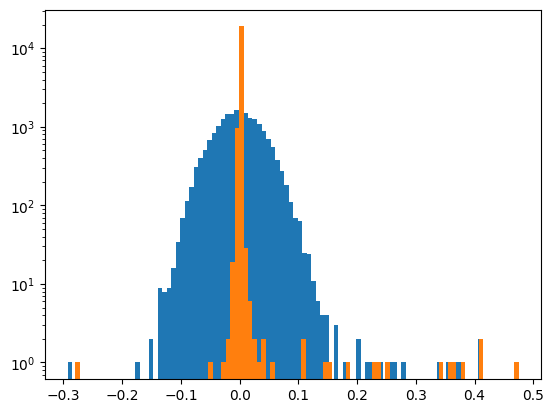

In [43]:
i = 6820
plt.hist(acts_orig[:,i].cpu(),100)
plt.hist(acts[:,i].cpu(),100)
plt.yscale('log')

In [31]:
feat_ids = torch.arange(acts.shape[1]).to('mps')[acts[i].abs() > 0.1]
feat_ids

tensor([3940, 4684, 6820, 7612, 8936], device='mps:0')

In [32]:
x = factors[feat_ids]
x @ x.T

tensor([[ 1.0000,  0.0726,  0.0880, -0.0964, -0.0823],
        [ 0.0726,  1.0000,  0.0899, -0.0580, -0.0761],
        [ 0.0880,  0.0899,  1.0000, -0.0848, -0.0818],
        [-0.0964, -0.0580, -0.0848,  1.0000,  0.0588],
        [-0.0823, -0.0761, -0.0818,  0.0588,  1.0000]], device='mps:0')

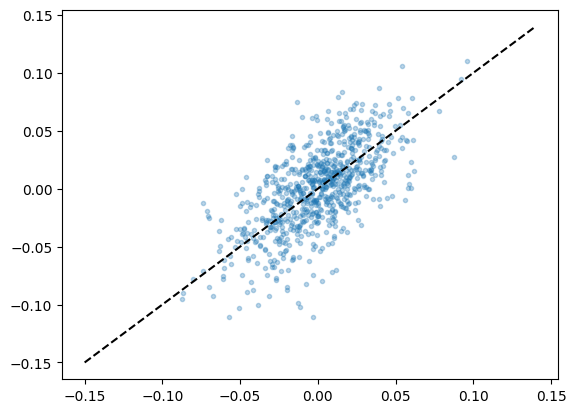

In [33]:
x = acts[i][feat_ids] @ factors[feat_ids]
y = decoders[i]
plt.plot(x.cpu(), y.cpu(), '.', alpha=0.3)
vec = np.arange(-0.15, 0.15, 0.01)
plt.plot(vec, vec, 'k--')

In [34]:
((x-y)**2).sum() / (y**2).sum()

tensor(0.5861, device='mps:0')

In [35]:
torch.corrcoef(torch.stack([x,y]))

tensor([[1.0000, 0.6517],
        [0.6517, 1.0000]], device='mps:0')

In [50]:
factors = factorizer.get_factors().detach()
acts_orig = factorizer.decoders @ factors.T
acts = factorizer.sim_activation(acts_orig) * acts_orig

factor_active = acts_orig.abs() > factorizer.cfg.theta
factor_num_acts = factor_active.sum(dim=0)

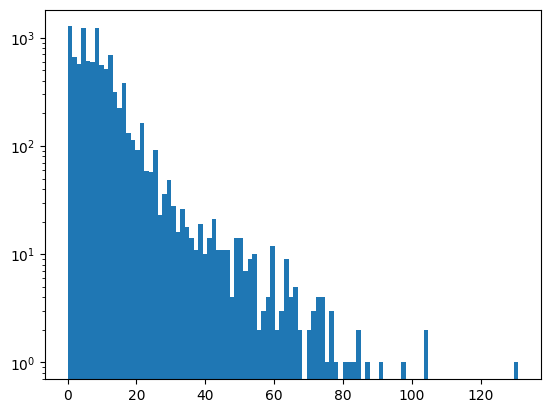

In [49]:
plt.hist(factor_num_acts.cpu(),100)
plt.yscale('log')

(array([162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.,  24.,  36.,  42.,  38.,  30.,  48.,  50.,  66.,
         73.,  72.,  75.,  92., 103., 111., 124., 128., 106., 149., 165.,
        110., 144., 188., 171., 189., 166., 198., 204., 186., 221., 306.,
        374., 487., 509., 514., 503., 509., 496., 506., 430., 405., 334.,
        262., 242., 169., 138.,  94.,  85.,  58.,  32.,  19.,  15.,   9.,
          8.,   2.,   2.,   1.,   2.,   0.,   1.,   2.,   2.,   1.,   0.,
          1.]),
 array([-6.        , -5.93714237, -5.87428474, -5.81142759, -5.74856997,
        -5.68571234, -5.62285471, -5.55999756, -5.49713993, -5.4342823 ,
        -5.37142467, -5.30856752, -5.2457099 , -5.18285227, -5.11999464,
        -5.05713749, -4.99427986, -4.93142223, -4.86856461, -4.80570698,
        -4.74284983, -4.67

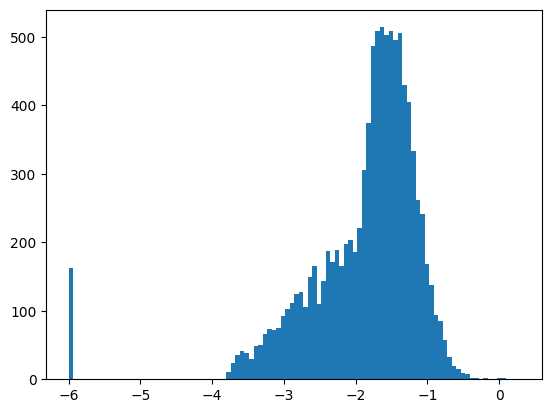

In [58]:
factor_sparsity = torch.log10(((10**sparsity[sort_ids][:20000]).to('mps')[:,None]  * factor_active.float()).sum(dim=0) + 1e-6)
plt.hist(factor_sparsity.cpu(),100)

In [57]:
factor_sparsity

tensor([-1.8735, -3.4058, -2.5945,  ..., -1.9919, -1.1228, -1.0792],
       device='mps:0')

In [55]:
sparsity

tensor([-3.5082, -3.2793, -3.0647,  ..., -3.6269, -2.8037, -3.1756])